# **Quanvolution 3×3 with lecture in 1 qubit and a CNN**
### *Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Autor: **Sebastián González Juárez**

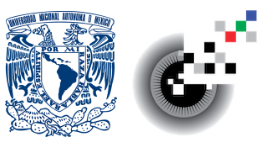

### **Resumen**
En este código opte por desarrollar un kernel 3x3 para poder crear un algoritmo cuántico variacional más expresivo, donde amplie tanto el feature map como el Ansatz. La idea era agrandar los bordes de la imagen para poder aplicar el parche 3x3 centrado en lo pixeles originales de la imagen, relacionar el pixel central con sus vecinos y al final hacer medición únicamente del pixel central para tener un solo canal. Este proyecto no obtuvo mejores resultados que el anterior y sin embargo el costo computacional se disparó por ser kernels más grandes. Es, por ende, que mejor he preferido centrar el documento explicativo en B_Quanvolution_CNN_PneumoniaMNIST.ipynb, pero aún así lo he decidido subir como aprendizaje y sobre todo por el gran contenido visual que tiene y tal vez contemplare una mejora con mejor desarrollo matemático. 

## **0) Imports, configuración básica y dispositivo**

In [1]:
import os, time, math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms
from medmnist import PneumoniaMNIST

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    f1_score
)

import pennylane as qml

# Semillas para reproducibilidad
SEED = 87
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Dispositivo local: GPU si hay, si no CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Trabajamos en float32 en todo el código
torch.set_default_dtype(torch.float32)

# Optimizaciones cuDNN (para convs en GPU)
torch.backends.cudnn.benchmark = True

print("Using device:", DEVICE)


Using device: cuda:0


## **1) Hiperparámetros**

In [2]:
# Etiquetas de la tarea binaria: sano vs neumonía
CLASS_POS = 1  # neumonía
CLASS_NEG = 0  # sano

# Parámetros de entrenamiento
BATCH_SIZE   = 32      # puedes subir a 64 si ves que corre bien
EPOCHS       = 20
LR           = 3.5e-5
WEIGHT_DECAY = 1e-5    # regularización L2 para las redes clásicas

# Configuración del bloque cuántico QLFO-9 (parches 3x3 → 9 qubits)
PATCH_SIZE   = 3
QUBITS       = PATCH_SIZE * PATCH_SIZE  # 9 qubits, uno por pixel
LAYERS       = 1                        # capas variacionales (empieza con 1)

# Parámetros del feature map
PI_FACTOR    = math.pi        # RY fuerte: π * p_i
EPS_RX       = 0.25 * math.pi # RX débil: ε * promedio_vecinos

# Estrella de entrelazamiento CRY: ángulo fijo (no entrenable)
LAMBDA_CRY   = 0.25 * math.pi # puedes probar π/12, π/16, etc.

# Configuración de PennyLane
DIFF_METHOD  = "backprop"  # diferenciación con PyTorch
SHOTS        = None        # simulación analítica (sin muestreo)

# Parámetros de la cabeza clásica
DROPOUT_P    = 0.20
OUT_DIM      = 1  # logit binario (antes de la sigmoide)


## **2) Preparación y carga de datos**

Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Train: 4708 | Val: 524 | Test: 624
Ejemplo shape batch: torch.Size([32, 1, 28, 28])


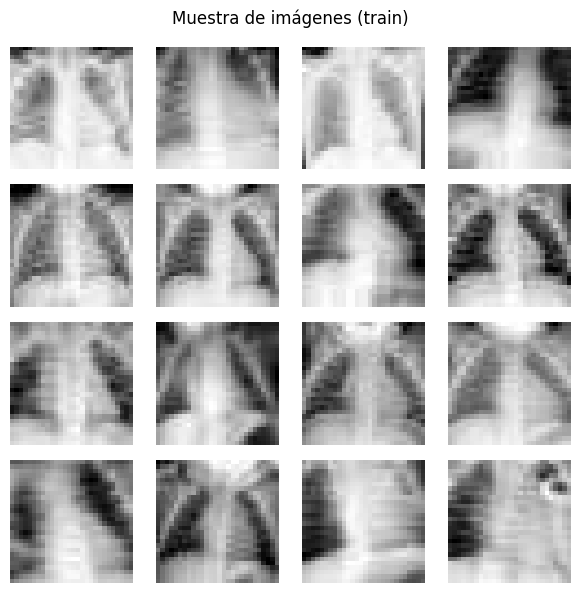

In [3]:
# Transformación básica: escalar a [0,1] y a tensor
tf = transforms.Compose([transforms.ToTensor()])

# Descarga / carga de MedMNIST
train_set = PneumoniaMNIST(split='train', transform=tf, download=True)
val_set   = PneumoniaMNIST(split='val',   transform=tf, download=True)
test_set  = PneumoniaMNIST(split='test',  transform=tf, download=True)

def to_tensors(ds):
    """
    Pasar el dataset de MedMNIST a tensores completos en memoria:
      xs: (N,1,28,28)
      ys: (N,)
    """
    xs = torch.stack([
        (ds[i][0] if isinstance(ds[i][0], torch.Tensor) else torch.as_tensor(ds[i][0]))
        .to('cpu').float()
        for i in range(len(ds))
    ], dim=0)  # (N,1,28,28)
    ys = torch.tensor([
        (ds[i][1].item() if hasattr(ds[i][1], "item") else np.asarray(ds[i][1]).item())
        for i in range(len(ds))
    ], dtype=torch.long, device='cpu')     # (N,)
    return xs, ys

# Tensores completos de cada split
X_tr, y_tr = to_tensors(train_set)
X_va, y_va = to_tensors(val_set)
X_te, y_te = to_tensors(test_set)

# DataLoaders. En Windows es más estable num_workers=0
g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(SEED)

num_w = 0
pin_mem = (DEVICE.type == 'cuda')

train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=g_cpu,
    num_workers=num_w,
    pin_memory=pin_mem
)
val_loader   = DataLoader(
    TensorDataset(X_va, y_va),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_w,
    pin_memory=pin_mem
)
test_loader  = DataLoader(
    TensorDataset(X_te, y_te),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_w,
    pin_memory=pin_mem
)

print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")
print("Ejemplo shape batch:", next(iter(train_loader))[0].shape)

# Visualización rápida de algunas imágenes de entrenamiento
imgs, ys = next(iter(train_loader))
fig, axs = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(imgs[i,0].numpy(), cmap='gray'); ax.axis('off')
plt.suptitle("Muestra de imágenes (train)"); plt.tight_layout(); plt.show()


## **3) Dispositivo cuántico y QNode batched**

In [4]:
# Dispositivo de PennyLane en Torch (GPU si hay)
pl_torch_device = "cuda" if DEVICE.type == "cuda" else "cpu"

dev = qml.device(
    "default.qubit.torch",
    wires=QUBITS,
    shots=SHOTS,
    torch_device=pl_torch_device
)

# Índice del qubit central (q5) en 0..8  → centro de la rejilla 3x3
CENTER_IDX = 4

# Vecinos (por índice 0..8) que se acoplan a q5 vía CRY
NEIGHBOR_IDX_STAR = [0, 1, 2, 3, 5, 6, 7, 8]


@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
def qlfo9_circuit_batched(theta_ry, theta_rx, weights_loc):
    """
    QNode batched para el filtro QLFO-9.

    theta_ry: (N,9)  ángulos fuertes RY (pixel propio)
    theta_rx: (N,9)  ángulos débiles RX (promedio vecinos, cero para centro)
    weights_loc: (LAYERS, 9, 3) parámetros locales RZ–RY–RZ
    """
    # Feature map: RY fuerte + RX débil (excepto centro)
    for q in range(QUBITS):
        qml.RY(theta_ry[:, q], wires=q)
        if q != CENTER_IDX:
            qml.RX(theta_rx[:, q], wires=q)

    # Bloques variacionales locales + estrella CRY de vecinos → centro
    for l in range(LAYERS):
        # Rotaciones locales RZ–RY–RZ
        for q in range(QUBITS):
            a = weights_loc[l, q, 0]
            b = weights_loc[l, q, 1]
            c = weights_loc[l, q, 2]
            qml.RZ(a, wires=q)
            qml.RY(b, wires=q)
            qml.RZ(c, wires=q)

        # Estrella CRY con λ fijo desde vecinos → centro
        for q in NEIGHBOR_IDX_STAR:
            qml.CRY(LAMBDA_CRY, wires=[q, CENTER_IDX])

    # Medición únicamente del qubit central q5
    return qml.expval(qml.PauliZ(CENTER_IDX))


## **4) Capa Quanv3x3_QLFO9**

In [5]:
class Quanv3x3_QLFO9(nn.Module):
    def __init__(self, chunk_patches: int | None = 4096):
        super().__init__()
        # Parámetros locales del ansatz: (LAYERS, QUBITS, 3) para RZ–RY–RZ
        self.weights_loc = nn.Parameter(
            0.1 * torch.randn(LAYERS, QUBITS, 3, device=DEVICE)
        )
        self.chunk_size = chunk_patches
        self._dbg_printed = False

        # Mapa de vecinos para el RX débil en el feature map (sin usar p5)
        # Índices 0..8 representan:
        # 0 1 2
        # 3 4 5
        # 6 7 8
        self.neighbors = {
            0: [1, 3],     # q1 ← p2, p4
            1: [0, 2],     # q2 ← p1, p3
            2: [1, 5],     # q3 ← p2, p6
            3: [0, 6],     # q4 ← p1, p7
            4: [],         # q5 (centro) sin RX
            5: [2, 8],     # q6 ← p3, p9
            6: [3, 7],     # q7 ← p4, p8
            7: [6, 8],     # q8 ← p7, p9
            8: [5, 7],     # q9 ← p6, p8
        }

    def _build_angles(self, patches: torch.Tensor):
        """
        patches: (N, 9) intensidades en [0,1]
        Devuelve:
          theta_ry: (N,9)
          theta_rx: (N,9)
        """
        # RY fuerte con el pixel propio
        theta_ry = PI_FACTOR * patches  # (N,9)

        # RX débil con el promedio de vecinos (sin centro)
        theta_rx = torch.zeros_like(patches)

        for i in range(QUBITS):
            if i == CENTER_IDX:
                continue  # centro sin RX
            idxs = self.neighbors[i]
            if len(idxs) > 0:
                neigh_vals = patches[:, idxs]      # (N, k)
                mean_neigh = neigh_vals.mean(dim=1)  # (N,)
                theta_rx[:, i] = EPS_RX * mean_neigh

        return theta_ry, theta_rx

    def forward(self, x: torch.Tensor):
        """
        x: (B,1,28,28)
        Salida: (B,1,28,28) con valores en [-1,1] aprox (⟨Z5⟩)
        """
        B, C, H, W = x.shape
        assert C == 1 and H == 28 and W == 28, "Esperaba entrada (B,1,28,28)."

        # Padding tipo "replicate" para obtener 30x30 y usar parches 3x3 centrados
        xpad = F.pad(x, (1,1,1,1), mode="replicate")   # (B,1,30,30)

        # Unfold a parches 3x3, stride=1 → 28*28 parches por imagen
        patches = F.unfold(xpad, kernel_size=3, stride=1)   # (B,9,784)
        patches = patches.transpose(1, 2).reshape(-1, 9)    # (B*784,9)
        patches = patches.contiguous()

        # Construyo los ángulos del feature map
        theta_ry, theta_rx = self._build_angles(patches)    # (N,9), (N,9)

        # Paso por el QNode en chunks si hace falta
        N = patches.shape[0]
        outs_list = []
        if self.chunk_size is None:
            theta_ry_dev = theta_ry.to(DEVICE)
            theta_rx_dev = theta_rx.to(DEVICE)
            out_all = qlfo9_circuit_batched(theta_ry_dev, theta_rx_dev, self.weights_loc)
            outs_list.append(out_all)
        else:
            for start in range(0, N, self.chunk_size):
                end = min(start + self.chunk_size, N)
                a_ry = theta_ry[start:end].to(DEVICE)
                a_rx = theta_rx[start:end].to(DEVICE)
                out_chunk = qlfo9_circuit_batched(a_ry, a_rx, self.weights_loc)  # (n_chunk,)
                outs_list.append(out_chunk)

        outs = torch.cat(outs_list, dim=0)                   # (N,)
        outs = outs.view(B, H*W, 1).permute(0, 2, 1)         # (B,1,784)
        outs = outs.contiguous().view(B, 1, H, W)            # (B,1,28,28)
        outs = outs.to(x.dtype)                              # float32

        if not self._dbg_printed:
            print(f"[Quanv QLFO-9] out: {outs.shape}, dtype={outs.dtype}, chunk={self.chunk_size}")
            self._dbg_printed = True

        return outs


## **5) Modelo completo: QCNN = Quanv3x3_QLFO9 + ConvHead**

In [6]:
class ConvHead(nn.Module):
    def __init__(self, in_channels=1, dropout_p=DROPOUT_P, out_dim=OUT_DIM):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 14x14 -> 7x7
        )
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, out_dim)

    def forward(self, z):
        z = self.cnn(z)                # (B,32,7,7)
        B = z.shape[0]
        z = z.view(B, -1)              # (B,32*7*7)
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = self.fc2(z)                # (B,1)
        return z


class QCNN_QLFO9(nn.Module):
    def __init__(self):
        super().__init__()
        self.quanv = Quanv3x3_QLFO9(chunk_patches=4096)
        self.head  = ConvHead(in_channels=1, dropout_p=DROPOUT_P, out_dim=OUT_DIM)

    def forward(self, x):
        xq = self.quanv(x)  # (B,1,28,28)
        logits = self.head(xq)  # (B,1)
        return logits.view(-1)


def build_qcnn():
    model = QCNN_QLFO9().to(DEVICE)
    return model


model = build_qcnn()
print(model)

# Prueba rápida de forward
xb_test, _ = next(iter(train_loader))
xb_test = xb_test.to(DEVICE)
with torch.no_grad():
    out_q = model(xb_test)
print("Salida QCNN shape:", out_q.shape)


QCNN_QLFO9(
  (quanv): Quanv3x3_QLFO9()
  (head): ConvHead(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=1568, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
  )
)
[Quanv QLFO-9] out: torch.Size([32, 1, 28, 28]), dtype=torch.float32, chunk=4096
Salida QCNN shape: torch.Size([32])


## **6) Función de visualización por época**

In [7]:
def visualize_quanv_epoch(model, dloader, epoch, device=DEVICE):
    model.eval()
    with torch.no_grad():
        xb, yb = next(iter(dloader))
        xb = xb.to(device, non_blocking=True)

        # Paso solo por la capa quanvolucional
        zq = model.quanv(xb)           # (B,1,28,28)

        x0 = xb[0, 0].detach().cpu()   # (28,28)
        z0 = zq[0, 0].detach().cpu()   # (28,28)

    # Figura: original vs cuántica (gray + mapa tipo "heat")
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle(f"Época {epoch} - Ejemplo imagen 0", fontsize=12)

    axs[0].imshow(x0, cmap="gray")
    axs[0].set_title("Imagen original")
    axs[0].axis("off")

    axs[1].imshow(z0, cmap="gray")
    axs[1].set_title("Quanv QLFO-9 (gray)")
    axs[1].axis("off")

    im2 = axs[2].imshow(z0, cmap="viridis")
    axs[2].set_title("Quanv QLFO-9 (heat)")
    axs[2].axis("off")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


## **7) Entrenamiento**

[Info] pos_weight (train): 0.347  (pos=3494, neg=1214)
[QCNN Ep 01] 303.6s  tr_loss=0.3423  val_loss=0.3200  val_auc=0.957  thr*=0.464  val_acc@thr*=91.4%  val_f1@thr*=0.941


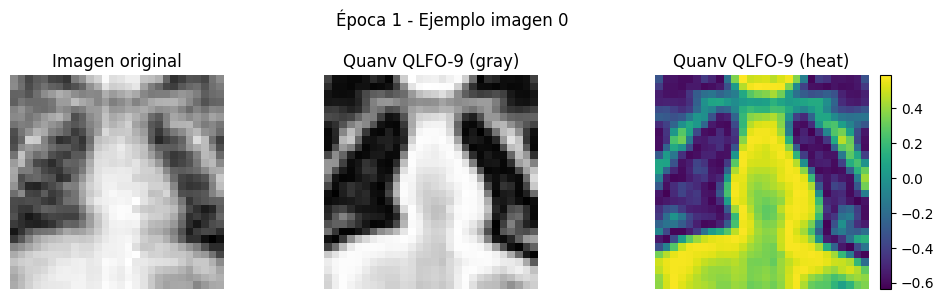

[QCNN Ep 02] 303.7s  tr_loss=0.2871  val_loss=0.2494  val_auc=0.953  thr*=0.445  val_acc@thr*=90.8%  val_f1@thr*=0.938


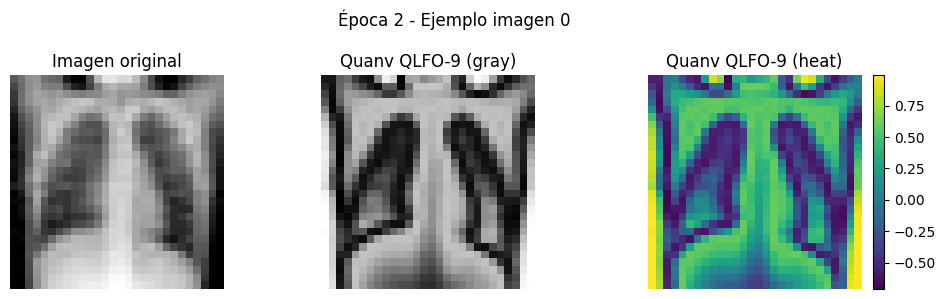

[QCNN Ep 03] 303.1s  tr_loss=0.2168  val_loss=0.1883  val_auc=0.958  thr*=0.464  val_acc@thr*=90.1%  val_f1@thr*=0.931


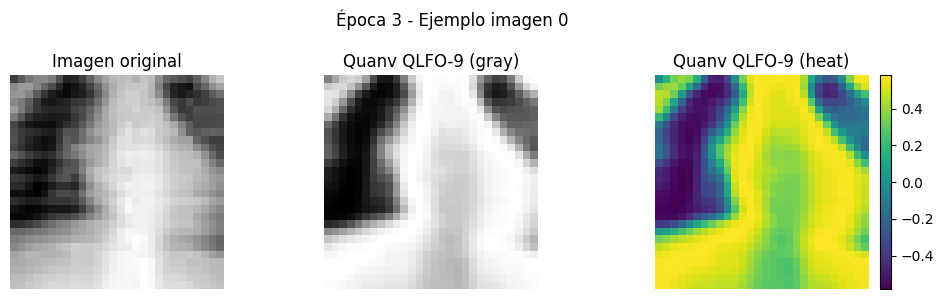

[QCNN Ep 04] 303.7s  tr_loss=0.1727  val_loss=0.1546  val_auc=0.965  thr*=0.418  val_acc@thr*=92.0%  val_f1@thr*=0.945


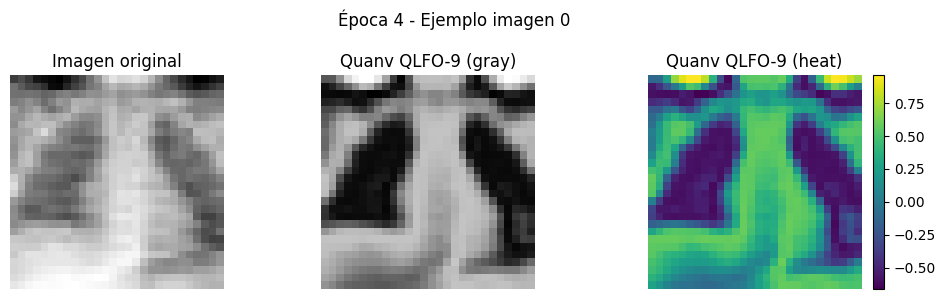

[QCNN Ep 05] 303.1s  tr_loss=0.1486  val_loss=0.1373  val_auc=0.968  thr*=0.451  val_acc@thr*=93.1%  val_f1@thr*=0.954


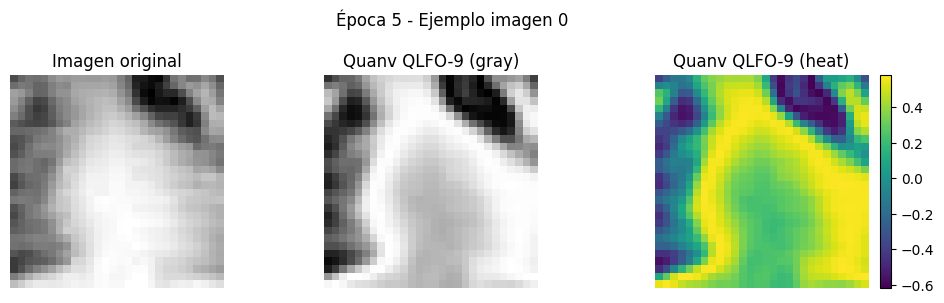

[QCNN Ep 06] 303.7s  tr_loss=0.1358  val_loss=0.1258  val_auc=0.971  thr*=0.439  val_acc@thr*=92.9%  val_f1@thr*=0.952


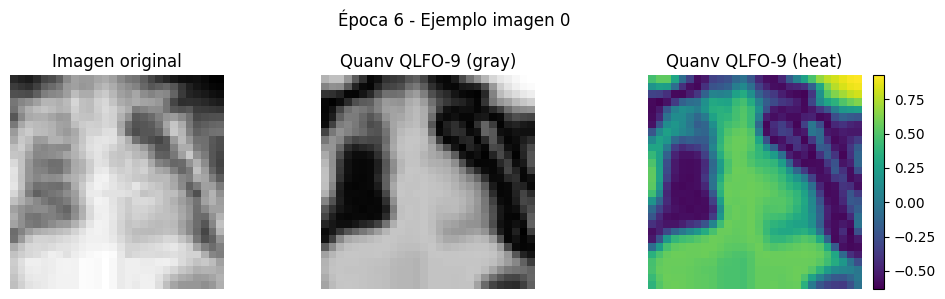

[QCNN Ep 07] 304.0s  tr_loss=0.1273  val_loss=0.1210  val_auc=0.972  thr*=0.389  val_acc@thr*=92.6%  val_f1@thr*=0.949


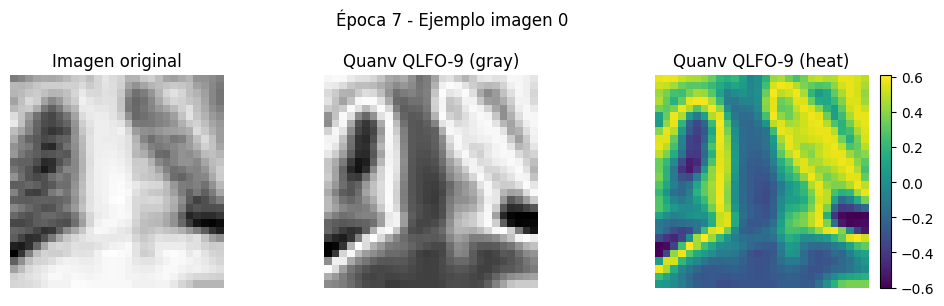

[QCNN Ep 08] 303.0s  tr_loss=0.1234  val_loss=0.1160  val_auc=0.973  thr*=0.351  val_acc@thr*=93.7%  val_f1@thr*=0.957


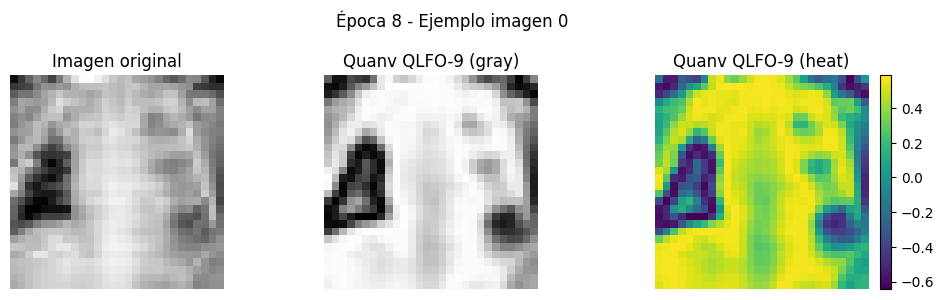

[QCNN Ep 09] 301.9s  tr_loss=0.1186  val_loss=0.1129  val_auc=0.974  thr*=0.364  val_acc@thr*=93.5%  val_f1@thr*=0.956


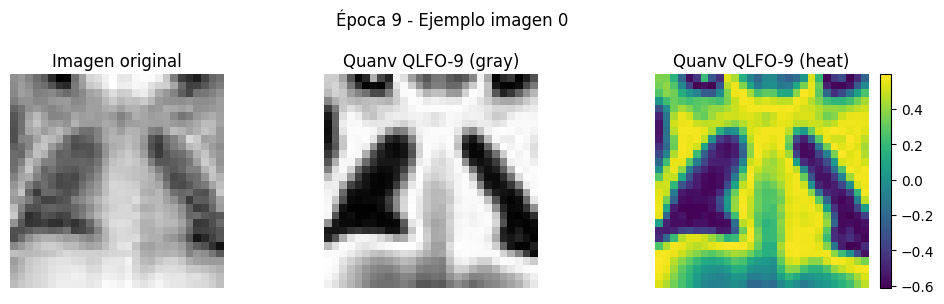

[QCNN Ep 10] 302.9s  tr_loss=0.1143  val_loss=0.1106  val_auc=0.975  thr*=0.283  val_acc@thr*=94.3%  val_f1@thr*=0.961


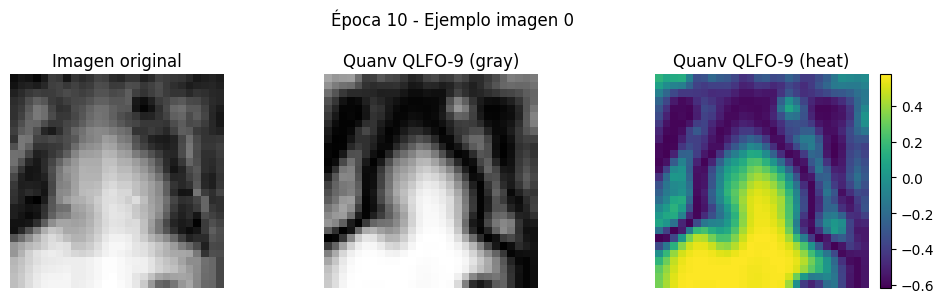

[QCNN Ep 11] 301.8s  tr_loss=0.1117  val_loss=0.1077  val_auc=0.975  thr*=0.492  val_acc@thr*=93.5%  val_f1@thr*=0.956


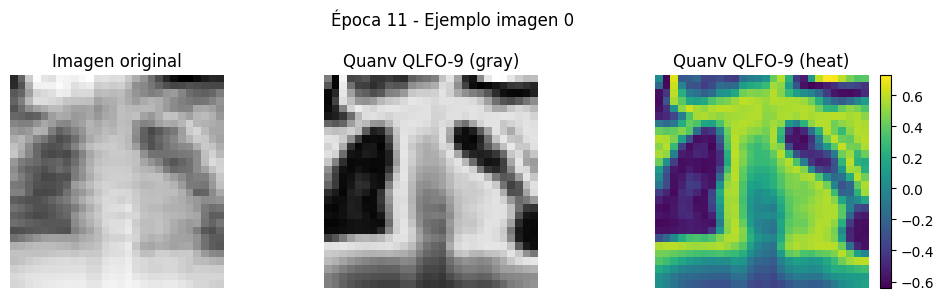

[QCNN Ep 12] 302.2s  tr_loss=0.1102  val_loss=0.1067  val_auc=0.976  thr*=0.386  val_acc@thr*=93.7%  val_f1@thr*=0.957


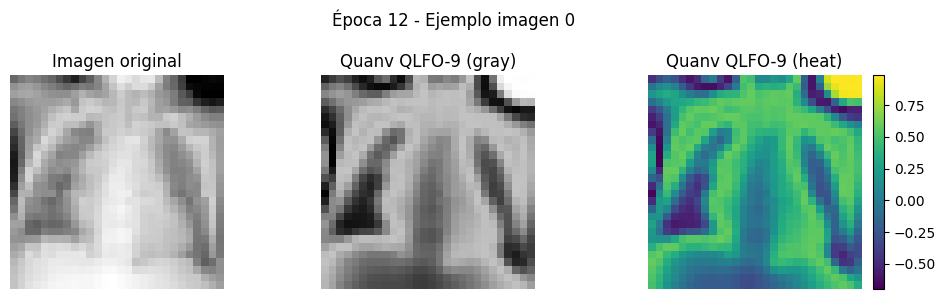

[QCNN Ep 13] 301.5s  tr_loss=0.1082  val_loss=0.1054  val_auc=0.976  thr*=0.254  val_acc@thr*=95.0%  val_f1@thr*=0.967


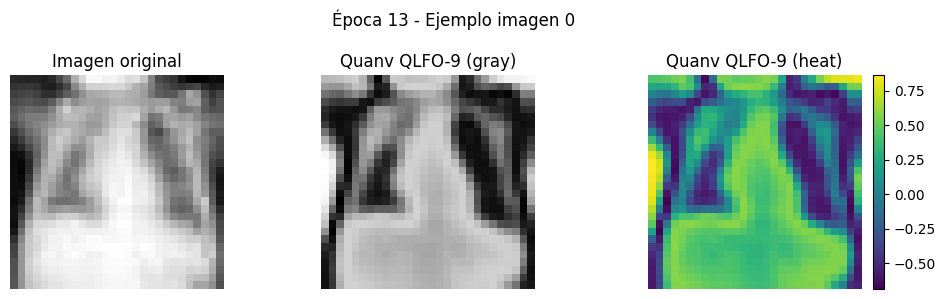

[QCNN Ep 14] 301.9s  tr_loss=0.1065  val_loss=0.1035  val_auc=0.977  thr*=0.424  val_acc@thr*=94.1%  val_f1@thr*=0.960


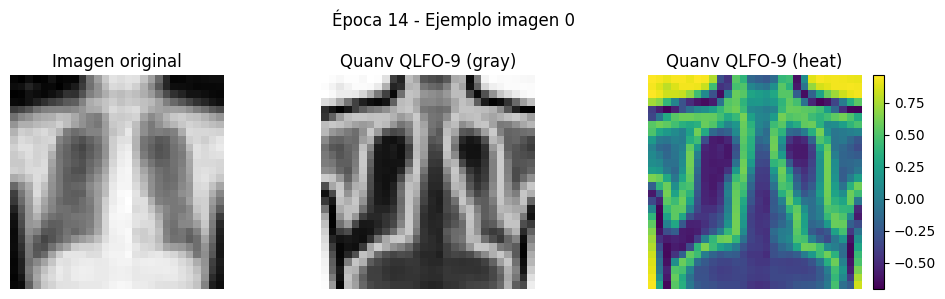

[QCNN Ep 15] 302.3s  tr_loss=0.1033  val_loss=0.1024  val_auc=0.977  thr*=0.362  val_acc@thr*=94.3%  val_f1@thr*=0.961


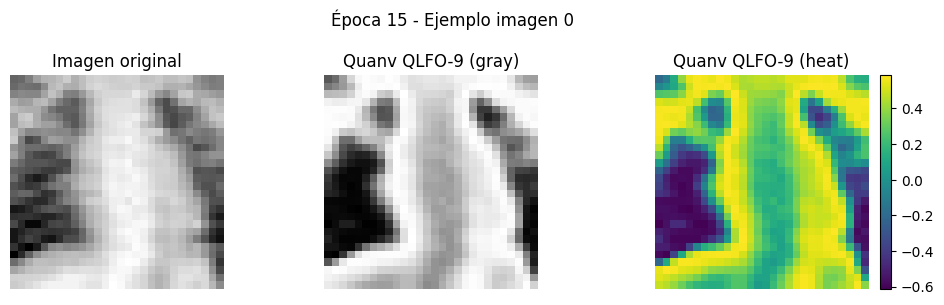

[QCNN Ep 16] 302.0s  tr_loss=0.1011  val_loss=0.1017  val_auc=0.977  thr*=0.447  val_acc@thr*=94.5%  val_f1@thr*=0.962


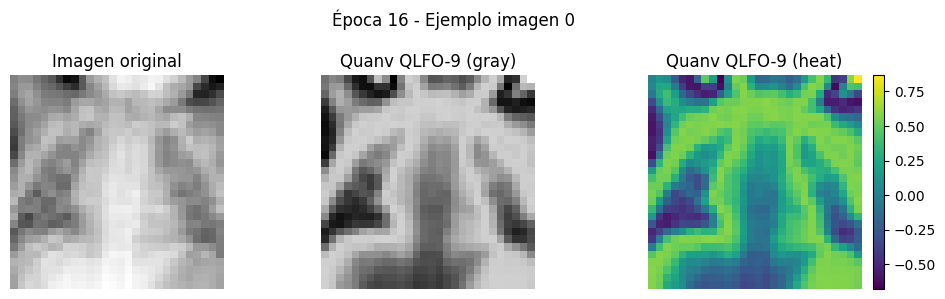

[QCNN Ep 17] 302.0s  tr_loss=0.1005  val_loss=0.1001  val_auc=0.978  thr*=0.364  val_acc@thr*=94.5%  val_f1@thr*=0.962


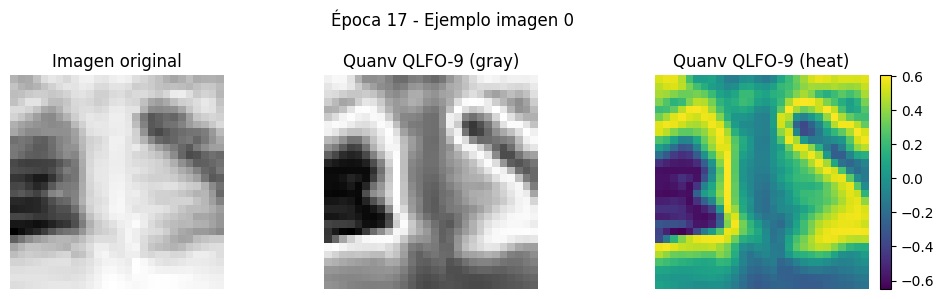

[QCNN Ep 18] 301.6s  tr_loss=0.1002  val_loss=0.0999  val_auc=0.978  thr*=0.310  val_acc@thr*=94.8%  val_f1@thr*=0.965


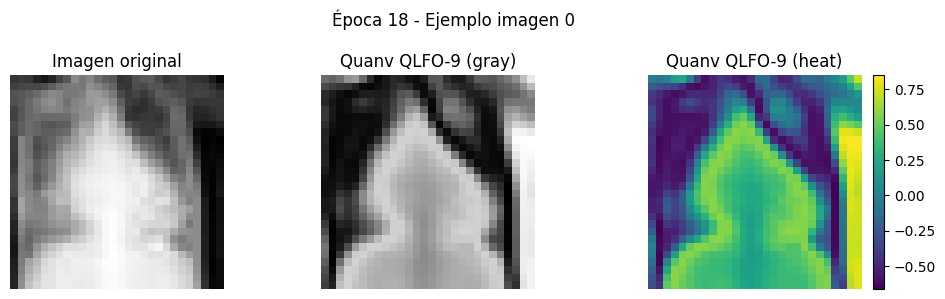

[QCNN Ep 19] 302.5s  tr_loss=0.0968  val_loss=0.0992  val_auc=0.978  thr*=0.300  val_acc@thr*=95.0%  val_f1@thr*=0.966


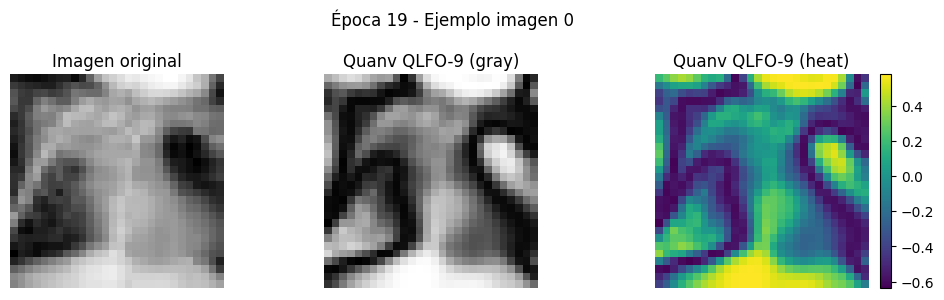

[QCNN Ep 20] 301.7s  tr_loss=0.0963  val_loss=0.1011  val_auc=0.979  thr*=0.242  val_acc@thr*=95.2%  val_f1@thr*=0.968


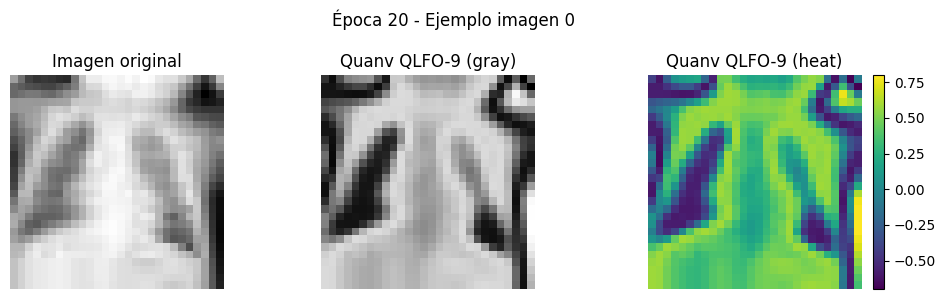

[Info] Mejor estado QCNN restaurado (val_loss=0.0992, thr*=0.300)


In [8]:
# Peso para la clase positiva según desbalance en train
with torch.no_grad():
    n_pos = int((y_tr == CLASS_POS).sum())
    n_neg = int((y_tr == CLASS_NEG).sum())
pos_weight_val = n_neg / max(1, n_pos)
print(f"[Info] pos_weight (train): {pos_weight_val:.3f}  (pos={n_pos}, neg={n_neg})")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=DEVICE, dtype=torch.float32)
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


def _best_threshold(y_true, probs):
    fpr, tpr, thrs = roc_curve(y_true, probs)
    youden = tpr - fpr
    idx = np.argmax(youden)
    return thrs[idx]


def train_epoch_q(dloader):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb)  # (B,)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = (logits >= 0).long()
        total_correct += (preds == yb.long()).sum().item()
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc


@torch.no_grad()
def eval_epoch_q(dloader):
    model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb)  # (B,)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    avg_loss = total_loss / total_samples
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()

    probs = 1.0 / (1.0 + np.exp(-logits))

    try:
        auc = roc_auc_score(y_true, probs)
    except Exception:
        auc = float("nan")

    thr_star = _best_threshold(y_true, probs)

    y_hat_thr = (probs >= thr_star).astype(int)
    acc_thr   = accuracy_score(y_true, y_hat_thr)
    f1_thr    = f1_score(y_true, y_hat_thr)

    y_hat_05 = (probs >= 0.5).astype(int)
    acc_05   = accuracy_score(y_true, y_hat_05)
    f1_05    = f1_score(y_true, y_hat_05)

    return avg_loss, acc_thr, auc, f1_thr, thr_star, acc_05, f1_05


# Historia de entrenamiento QCNN
history = {
    "tr_loss": [], "tr_acc05": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [], "va_f105": []
}
history_theta = []  # pesos cuánticos por época

best_val_loss = float('inf')
best_state    = None
best_thr_val  = 0.5

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_epoch_q(train_loader)
    va_loss, va_acc_thr, va_auc, va_f1_thr, thr_star, va_acc05, va_f105 = eval_epoch_q(val_loader)
    dt = time.time() - t0

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state    = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_thr_val  = thr_star

    history["tr_loss"].append(tr_loss)
    history["tr_acc05"].append(tr_acc)
    history["va_loss"].append(va_loss)
    history["va_auc"].append(va_auc)
    history["va_acc_thr"].append(va_acc_thr)
    history["va_f1_thr"].append(va_f1_thr)
    history["va_thr"].append(thr_star)
    history["va_acc05"].append(va_acc05)
    history["va_f105"].append(va_f105)

    # guardo copia de pesos cuánticos (solo locales RZ–RY–RZ)
    history_theta.append(model.quanv.weights_loc.detach().cpu().clone())

    print(f"[QCNN Ep {ep:02d}] {dt:.1f}s  "
          f"tr_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  "
          f"val_auc={va_auc:.3f}  thr*={thr_star:.3f}  "
          f"val_acc@thr*={va_acc_thr*100:.1f}%  val_f1@thr*={va_f1_thr:.3f}")

    # Visualización por época
    visualize_quanv_epoch(model, train_loader, ep, device=DEVICE)

# Restaurar mejor estado
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f"[Info] Mejor estado QCNN restaurado (val_loss={best_val_loss:.4f}, thr*={best_thr_val:.3f})")


## **8) Gráficas de pérdida y accuracy (Train/Val)**

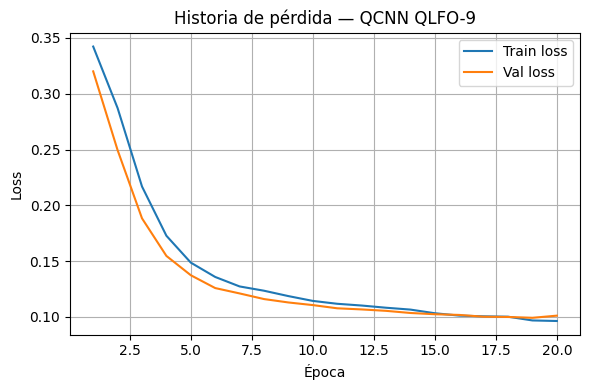

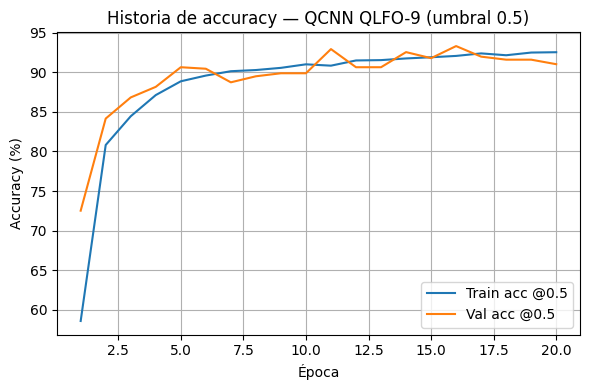

In [9]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, history["tr_loss"], label="Train loss")
plt.plot(epochs_range, history["va_loss"], label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Historia de pérdida — QCNN QLFO-9")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, [x*100 for x in history["tr_acc05"]], label="Train acc @0.5")
plt.plot(epochs_range, [x*100 for x in history["va_acc05"]], label="Val acc @0.5")
plt.xlabel("Época")
plt.ylabel("Accuracy (%)")
plt.title("Historia de accuracy — QCNN QLFO-9 (umbral 0.5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **9) Test completo**

In [10]:
@torch.no_grad()
def eval_test_qcnn(dloader, threshold):
    model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb)  # (B,)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    avg_loss = total_loss / total_samples
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()
    probs    = 1.0 / (1.0 + np.exp(-logits))

    y_hat = (probs >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1_, _ = precision_recall_fscore_support(
        y_true, y_hat,
        average="binary",
        pos_label=CLASS_POS,
        zero_division=0
    )

    try:
        auc = roc_auc_score(y_true, probs)
    except Exception:
        auc = float("nan")

    try:
        pr_auc = average_precision_score(y_true, probs)
    except Exception:
        pr_auc = float("nan")

    cm = confusion_matrix(y_true, y_hat)
    report = classification_report(y_true, y_hat, digits=3)

    return {
        "loss": avg_loss,
        "acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_,
        "auc": auc,
        "pr_auc": pr_auc,
        "cm": cm,
        "report": report,
        "threshold": threshold,
    }

def print_test_qcnn(tag, res):
    print(f"\n[{tag}] thr={res['threshold']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.2f}% "
          f"| precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['pr_auc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("Reporte por clase:\n", res["report"])

res_qcnn_05 = eval_test_qcnn(test_loader, 0.5)
res_qcnn_ts = eval_test_qcnn(test_loader, best_thr_val)

print_test_qcnn("QCNN QLFO-9 @0.5", res_qcnn_05)
print_test_qcnn("QCNN QLFO-9 @thr*", res_qcnn_ts)



[QCNN QLFO-9 @0.5] thr=0.500
loss=0.2561 | acc=86.54% | precision=0.881 | recall=0.908 | F1=0.894
AUC=0.924 | PR-AUC=0.947
Matriz de confusión:
 [[186  48]
 [ 36 354]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.838     0.795     0.816       234
         1.0      0.881     0.908     0.894       390

    accuracy                          0.865       624
   macro avg      0.859     0.851     0.855       624
weighted avg      0.865     0.865     0.865       624


[QCNN QLFO-9 @thr*] thr=0.300
loss=0.2561 | acc=83.81% | precision=0.820 | recall=0.949 | F1=0.880
AUC=0.924 | PR-AUC=0.947
Matriz de confusión:
 [[153  81]
 [ 20 370]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.884     0.654     0.752       234
         1.0      0.820     0.949     0.880       390

    accuracy                          0.838       624
   macro avg      0.852     0.801     0.816       624
weighted avg      0.84

## **10) Evolución de parámetros cuánticos (ansatz)**

[Info] Parámetros cuánticos totales: 27 (LAYERS*QUBITS*3)


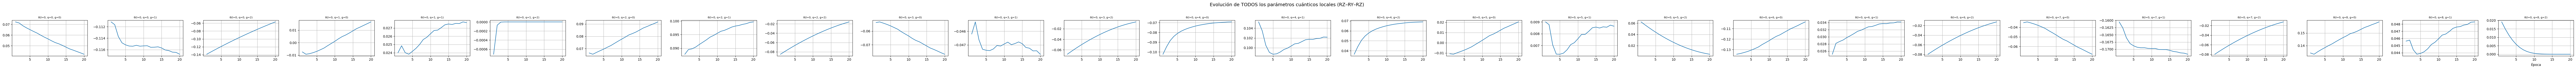

In [11]:
# history_theta: lista de longitud EPOCHS, cada elemento (LAYERS, QUBITS, 3)
theta_arr = torch.stack(
    [ht.view(-1) for ht in history_theta],
    dim=0
).numpy()  # shape: (EPOCHS, n_params)

n_params = theta_arr.shape[1]
print(f"[Info] Parámetros cuánticos totales: {n_params} (LAYERS*QUBITS*3)")

fig, axs = plt.subplots(LAYERS, QUBITS*3, figsize=(4*(QUBITS*3), 3*LAYERS), sharex=True)
if LAYERS == 1:
    axs = np.expand_dims(axs, axis=0)  # para indexar axs[l, ...]

fig.suptitle("Evolución de TODOS los parámetros cuánticos locales (RZ–RY–RZ)", fontsize=14)

idx = 0
for l in range(LAYERS):
    for q in range(QUBITS):
        for g in range(3):
            ax = axs[l, 3*q + g]
            ax.plot(epochs_range, theta_arr[:, idx])
            ax.set_title(f"θ(l={l}, q={q}, g={g})", fontsize=8)
            ax.grid(True)
            idx += 1

plt.xlabel("Época")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
